# Load Training Data

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from robot_tools.trajer import TrajTools, recorder, TrajsPainter
data = recorder.json_process("data_sim_1.json")

(obs_trajs, obs_info) = TrajTools.construct_trajs(
    data, key="observation", series_type="h", mixed_type="h"
)

(act_trajs, act_info) = TrajTools.construct_trajs(
    data, key="action", series_type="h", mixed_type="h"
)
n_states = obs_info.features_num  # Number of states
n_inputs = act_info.features_num  # Number of control inputs

n_traj = obs_info.trajs_num  # Number of trajectories
assert n_traj == act_info.trajs_num, "Number of trajectories not match"
n_int = int(obs_info.max_points_num - 1)  # Integration length
assert (
    n_int == act_info.max_points_num - 1
).all(), "Number of integration points not match"
print("Number of trajectories: ", n_traj)
print("Number of states: ", n_states)
print("Number of inputs: ", n_inputs)
print("Number of max integration points: ", n_int)
# obs_trajs[2][2,:] *= 100
# mixed trajectory
X, X_info = TrajTools.delete_mixed_at_time(obs_trajs[2], -1, obs_info)
Y, Y_info = TrajTools.delete_mixed_at_time(obs_trajs[2], 0, obs_info)
U, U_info = TrajTools.delete_mixed_at_time(act_trajs[2], -1, act_info)
# U *= 100
print(X[:, :3])
print(Y[:, :3])
print(U[:, :3])
assert X_info.max_points_num == Y_info.max_points_num == U_info.max_points_num

Number of trajectories:  1
Number of states:  3
Number of inputs:  3
Number of max integration points:  31
[[207.04348755 117.58218384  99.50003052]
 [127.30657959 119.78076172  73.5       ]
 [  0.36314698   0.35877071   0.        ]]
[[117.58218384  99.50003052  99.5       ]
 [119.78076172  73.5         73.5       ]
 [  0.35877071   0.           0.        ]]
[[0.         0.02070435 0.01175822]
 [0.02043355 0.         0.        ]
 [0.         0.         0.35877071]]


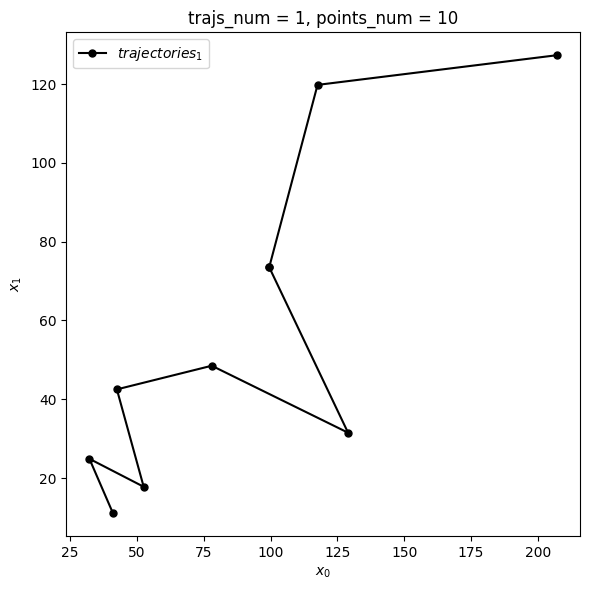

In [2]:
# 展示训练轨迹
train_points_num = 10
obs_painter = TrajsPainter(obs_trajs[2], obs_info)
obs_painter.plot_2D_features((0, train_points_num), (0,), (0, 1))

# Koopman using EDMDc

## Training

In [3]:
import pykoopman as pk
import warnings
import numpy as np
np.random.seed(42)  # for reproducibility
warnings.filterwarnings("ignore")
from pykoopman.regression import EDMDc
from pykoopman.observables import RadialBasisFunction, Polynomial

In [7]:
EDMDc_ = EDMDc()
rbf_type = "polyharmonic"  # 'thinplate' polyharmonic gauss invquad invmultquad
regressor = RadialBasisFunction(
    rbf_type=rbf_type,
    n_centers=20,
    centers=None,
    kernel_width=2.0,
    polyharmonic_coeff=2.0,
    include_state=True,
)
# regressor = Polynomial(degree=2)

model = pk.Koopman(observables=regressor, regressor=EDMDc_)
# 训练不使用全部的数据，只使用部分数据，因为后面的数据训练有问题
model.fit(X[:train_points_num].T, y=Y[:train_points_num].T, u=U[:train_points_num].T)

Koopman(observables=RadialBasisFunction(centers=array([[8.17505336e+01, 5.71765334e+01, 1.73919634e+02, 7.50641693e+01,
        5.91841788e+01, 1.14009240e+02, 2.98595060e+01, 1.68360811e+02,
        1.59577876e+01, 2.07043488e+02, 1.62087424e+02, 4.19637279e+01,
        1.50000000e+00, 1.71139004e+02, 1.48392252e+02, 1.53031457e+02,
        1.61883334e+02, 1.58518093e+01, 7.54228260e+01, 2.4611787...
       [0.00000000e+00, 2.44578446e-01, 1.14380072e-01, 1.92896115e-01,
        3.54199912e-01, 8.80764600e-02, 1.53201310e-01, 2.92743997e-01,
        7.97912339e-02, 1.84149935e-02, 1.04433090e-01, 5.24716292e-02,
        3.63146982e-01, 3.13996398e-01, 2.43362933e-01, 3.39603226e-01,
        3.12198063e-01, 6.27194897e-02, 3.48132773e-01, 2.05336267e-01]]),
                                        kernel_width=2.0, n_centers=20,
                                        polyharmonic_coeff=2.0,
                                        rbf_type='polyharmonic'),
        regressor=EDMDc())

In [8]:
# 在训练集上回归
start_point = 0
end_point = start_point + train_points_num
# 这里因为只有一个轨迹，所以采用了简化的方式
Xtrain = X[:, start_point:end_point]
input_x0 = X[:, start_point][np.newaxis, :]
input_u = U[:, start_point:end_point]

Xkoop = model.simulate(input_x0, input_u.T, n_steps=train_points_num - 1)
Xkoop = np.vstack([input_x0, Xkoop])  # add initial point
Xkoop = Xkoop.T

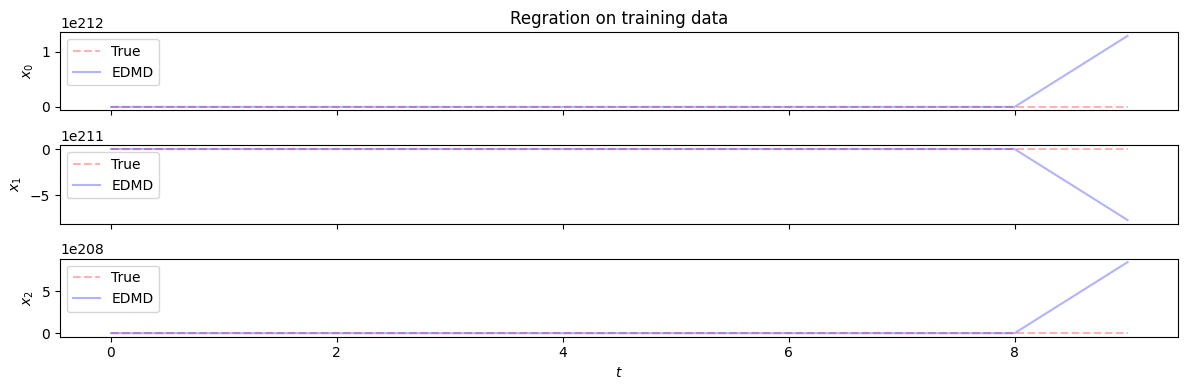

In [9]:
# 绘图
from robot_tools.trajer import TrajInfo

max_train_draw = train_points_num
Xkoop_info = Xtrain_info = TrajInfo.consruct(
    Xtrain,
    "mixed_h",
    1,
)

trajs_painter = TrajsPainter()
trajs_painter.update_trajs(Xtrain, Xtrain_info)
trajs_painter.features_self_labels = "True"
trajs_painter.features_lines = "--r"
trajs_painter.features_sharetitle = "Regration on training data"
axs = trajs_painter.plot_features_with_t(
    (0, max_train_draw), (0,), (0, 1, 2), return_axs=True
)

trajs_painter.update_trajs(Xkoop, Xkoop_info)
trajs_painter.features_self_labels = "EDMD"
trajs_painter.features_lines = "-b"
trajs_painter.plot_features_with_t((0, max_train_draw), (0,), (0, 1, 2), given_axs=axs)

In [ ]:
# 在训练集上预测
x = Xtrain[:, 0][np.newaxis, :]

Xk = Xtrain_info.get_trajs()
Yk = Xtrain_info.get_trajs()

for k in range(Xtrain_info.max_points_num):
    yT = model.predict(x, input_u[:, k])
    Xk[:, k*n_traj:(k+1)*n_traj] = x.T
    Yk[:, k*n_traj:(k+1)*n_traj] = yT.T
    x = yT
assert TrajTools.has_nan(Xk) == False, "Xk has nan"
assert TrajTools.has_nan(Yk) == False, "Yk has nan"

In [ ]:
# max_points_num = train_points_num
max_points_num = 15

Xk_info = Xtrain_info

trajs_painter = TrajsPainter()
trajs_painter.update_trajs(Xtrain, Xtrain_info)
trajs_painter.features_self_labels = "True Test"
trajs_painter.features_lines = "--r"
trajs_painter.features_sharetitle = "Prediciton on training data"
axs = trajs_painter.plot_features_with_t(
    (0, max_points_num), (0,), (0, 1, 2), return_axs=True
)

trajs_painter.update_trajs(Xk, Xk_info)
trajs_painter.features_self_labels = "Koopman Test"
trajs_painter.features_lines = "-b"
trajs_painter.plot_features_with_t((0, max_points_num), (0,), (0, 1, 2), given_axs=axs)

## Testing

In [ ]:
# 加载并绘制测试数据
test_points_num = 15

data_test = recorder.json_process("data_sim_2.json")

(obs_trajs_test, obs_info_test) = TrajTools.construct_trajs(
    data_test, key="observation", series_type="h", mixed_type="h"
)

(act_trajs_test, act_info_test) = TrajTools.construct_trajs(
    data_test, key="action", series_type="h", mixed_type="h"
)


X_test, X_test_info = TrajTools.get_sub_mixed_trajs(
    obs_trajs_test[2], obs_info_test, (0, test_points_num), (0,)
)

Y_test, Y_test_info = TrajTools.get_sub_mixed_trajs(
    obs_trajs_test[2], obs_info_test, (1, test_points_num+1), (0,)
)

U_test, U_test_info = TrajTools.get_sub_mixed_trajs(
    act_trajs_test[2], act_info_test, (0, test_points_num), (0,)
)

trajs_painter = TrajsPainter()
trajs_painter.update_trajs(X_test, X_test_info)
trajs_painter.features_sharetitle = "States Trajectories"
trajs_painter.features_self_labels = "Test X"
trajs_painter.features_lines = "--r"
axs = trajs_painter.plot_features_with_t(
    (0, test_points_num), (0,), (0, 1, 2), return_axs=True
)
u_painter = TrajsPainter(U_test, U_test_info)
u_painter.features_sharetitle = "Inputs Trajectories"
u_painter.features_self_labels = "Test U"
u_painter.features_lines = "--r"
u_painter.plot_features_with_t((0, test_points_num), (0,), (0,1,2))

test_painter = TrajsPainter(X_test, X_test_info)
test_painter.trajs_labels = "Test X"
axs = test_painter.plot_2D_features((0, test_points_num), (0,), (0, 1), return_axs=True)
test_painter.update_trajs(Y_test, Y_test_info)
test_painter.trajs_labels = "Test Y"
test_painter.trajs_lines = "->r"
test_painter.trajs_markersize = 3
test_painter.plot_2D_features((0, test_points_num), (0,), (0, 1), given_axs=axs)

In [ ]:
# 在测试集上预测
x = X_test[:, 0][np.newaxis, :]
Xk = X_test_info.get_trajs("mixed_h")
Yk = X_test_info.get_trajs("mixed_h")

for k in range(X_test_info.max_points_num):
    yT = model.predict(x, U_test[:, k])
    Xk[:, k * n_traj : (k + 1) * n_traj] = x.T
    Yk[:, k * n_traj : (k + 1) * n_traj] = yT.T
    x = yT
assert TrajTools.has_nan(Xk) == False, "Xk has nan"
assert TrajTools.has_nan(Yk) == False, "Yk has nan"
print(X_test[:, 0:3])
print(Xk[:, 0:3])

In [ ]:
trajs_painter = TrajsPainter()
trajs_painter.update_trajs(X_test, X_test_info)
trajs_painter.features_self_labels = "True Test"
trajs_painter.features_lines = "--r"
axs = trajs_painter.plot_features_with_t(
    (0, test_points_num), (0,), (0, 1, 2), return_axs=True
)

trajs_painter.update_trajs(Xk, X_test_info)
trajs_painter.features_self_labels = "Koopman Test"
trajs_painter.features_lines = "-b"
trajs_painter.plot_features_with_t((0, test_points_num), (0,), (0, 1, 2), given_axs=axs)
# trajs_painter.plot_features_with_t((0, 7), (0,), (0, 1, 2), given_axs=axs)

# 2D轨迹绘制

## Training

In [ ]:
obs_painter = TrajsPainter()
obs_painter.update_trajs(Xtrain, Xtrain_info)
obs_painter.trajs_labels = "Training trajectories"
axs = obs_painter.plot_2D_features((0, train_points_num), (0,), (0, 1), return_axs=True)
obs_painter.update_trajs(Xkoop, Xkoop_info)
obs_painter.trajs_labels = "Koopman prediction on training trajectories"
obs_painter.trajs_lines = "->r"
obs_painter.trajs_markersize = 3
obs_painter.plot_2D_features((0, train_points_num), (0,), (0, 1), given_axs=axs)

## Testing

In [ ]:
obs_painter = TrajsPainter()
obs_painter.update_trajs(X_test, X_test_info)
obs_painter.trajs_labels = "Testing trajectories"
axs = obs_painter.plot_2D_features((0, test_points_num), (0,), (0, 1), return_axs=True)
obs_painter.update_trajs(Xk, Xk_info)
obs_painter.trajs_labels = "Koopman prediction on testing trajectories"
obs_painter.trajs_lines = "->r"
obs_painter.trajs_markersize = 3
obs_painter.plot_2D_features((0, test_points_num), (0,), (0, 1), given_axs=axs)